# Language Models

In our pursuit of making computers understand and generate human-like text, LLM were developed.
Language modeling in general is concerned with predicting the next word in a sequence of words. One of the early and basic examples of LMs is the n-gram model, where the probability of a word occurring is calculated based on the previous n-1 words.

For example, in a 5-gram model, and the sentence "The quick brown fox jumps over the lazy dog", the probability of the word "dog" occuring is calculated based on the previous 4 words "over the lazy". This is a very simple model and does not capture the context of the sentence very well.

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2023/05/Language-Model-N-gram.jpg" />

source: https://www.baeldung.com/cs/large-language-models

## Large Language Models
The benifit of N-gram models is limited. This is where large language models (LLMs) come in. LLMs are able to capture the context of the sentence and generate more accurate predictions. They language models that use large neural networks with up to billions of parameters. They can capture more complex syntax and semantics of the human language. They can perform a number of tasks, ranging from translation, identifying offensive content, or even passing professional exams.

To further understand LLMs, we will introduce two concepts here, **embedding** and **tokenization**.

### Embeddings
You can think of embeddings as values assigned to words that represent aspects of their meaning. For example, if we want to describe objects in terms of their size and taste, a dog will score high on the size and low on the taste, while a rock will score low on both, and so on. When the model learns such values, it acquires some form of representation of word *meaning*. That is why, **embeddings are a major part of what the models are actually trained on**.

<img src="https://raw.githubusercontent.com/abdulrahman1123/analysis_examples/refs/heads/main/embeddings.png" width=400 height=423 />

### Tokenization and Encoding
Have you ever subscriped to the 'pay as you go' tier in ChatGPT, Cluade or Deepseek? If so, then you probably noticed that they calculate usage by the number of tokens. But what are tokens?
Well, they are the smallest chunks that you split your text into. Usually, they represent sub-word syllables. For example, the word "unbelievable" can consist of three tokens, "un", "believ" and "able". However, we can determine the granularity of our definition of tokens, and we can split our data on the letter level, or on the whole-word level if we want to.

Finally, we all know how computers love numbers. So, we want to convert all words to numbers before feeding them to the model for training. This is known as **encoding**. When we get the output of the machine, we convert it back to words using **decoding**.

<img src="https://raw.githubusercontent.com/abdulrahman1123/analysis_examples/refs/heads/main/tokenization.png" width=1050 height=225 />

Enough talk now. let's start coding.

-----

# Writing an LLM
### importing important functions and libraries
I created a file containing all important functions that we need. All we have to do now is clone my repository by running the following cell:

In [1]:
# Clone the repository and all its functions
!git clone https://github.com/abdulrahman1123/analysis_examples.git

# Add the cloned directory to Python path
import sys
sys.path.append('/content/analysis_examples')

# Import important functions, including functions to build the model and train it
from microGPT import *

Cloning into 'analysis_examples'...
Updating files:  40% (46/115)
Updating files:  41% (48/115)
Updating files:  42% (49/115)
Updating files:  43% (50/115)
Updating files:  44% (51/115)
Updating files:  45% (52/115)
Updating files:  46% (53/115)
Updating files:  47% (55/115)
Updating files:  48% (56/115)
Updating files:  49% (57/115)
Updating files:  50% (58/115)
Updating files:  51% (59/115)
Updating files:  52% (60/115)
Updating files:  53% (61/115)
Updating files:  54% (63/115)
Updating files:  55% (64/115)
Updating files:  56% (65/115)
Updating files:  57% (66/115)
Updating files:  58% (67/115)
Updating files:  59% (68/115)
Updating files:  60% (69/115)
Updating files:  61% (71/115)
Updating files:  62% (72/115)
Updating files:  63% (73/115)
Updating files:  64% (74/115)
Updating files:  65% (75/115)
Updating files:  66% (76/115)
Updating files:  67% (78/115)
Updating files:  68% (79/115)
Updating files:  69% (80/115)
Updating files:  70% (81/115)
Updating files:  71% (82/115)
Upda

## Shakespeare's Work
Let's download theentirety of Shakespeare's work to train our model.

In [2]:
url1 = "https://www.gutenberg.org/cache/epub/100/pg100.txt"
text = requests.get(url1).text.replace('\r','')
text = text[text.find('THE SONNETS\n\n')::] # remove text introduction
print(f"Length of dataset in characters: {len(text)}")
print(text[:302])

Length of dataset in characters: 5376417
THE SONNETS

                    1

From fairest creatures we desire increase,
That thereby beauty’s rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed’st thy light’s flame with self-substantial fuel,


### Hyperparameters
Hyperparameters are parameters that specify how the model is built and trained. 

In [ ]:

batch_size = 8 # how many independent sequences will we process in parallel
block_size = 16 # what is the maximum context length for predictions
max_iters = 1000
learning_rate = 2e-4
device = torch.device("cpu")
eval_iters = 100
eval_interval = max_iters//10
n_embd = 64
n_head = 2
n_layer = 2
n_embd = (n_embd//n_head)*n_head
dropout = 0.1
vocab_size = 10000


### Create Tokenizer, Encoder and Decoder functions
create Tokenizer, Encoder and Decoder functions. The encoder is used to feed encoded data to the model (numbers only), and the decoder is used to convert the model's output into characters.

Vocab size: 10000


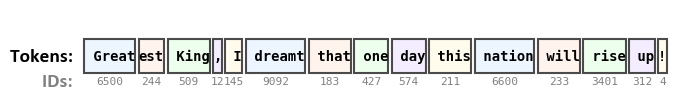

In [13]:
encode,decode, tokenizer, vocab_size = tokenize(text, vocab_size)

# check what it does
check_sentence = 'Greatest King, I dreamt that one day this nation will rise up!'
plot_sentence_tokens(check_sentence,tokenizer)


### Encode all text
Now encode the entire Shakespeare's text

In [14]:
data = torch.tensor(encode(text), dtype=torch.long)

### Training and Testing
I guess you are now familiar with the concept of training and testing. I wrote a simple function that splits the data into 90% training and 10% testing.

In [15]:
# split into training and testing
train_data, val_data = train_test_split(data, 0.9)
train_data, val_data = train_data.to(device), val_data.to(device)
print(f'Train size = {train_data.shape[0]} tokens ... Validation size = {val_data.shape[0]} tokens')

Train size = 1410580 tokens ... Validation size = 156740 tokens


### Creating the Model
Now we want to build the model and some optimizing functions, and then train the model. The model is a deep learning model that learns two major things:

- Different embeddings: You can look at the embeddings as a vector of numbers that represent a character. The model learns the embeddings of each character.
- Word affinity: the model learns the relationship between the word and previous words to understand the context better

<img src="https://raw.githubusercontent.com/abdulrahman1123/analysis_examples/refs/heads/main/story.png" width=800 />

In [30]:
model = BigramLanguageModel(vocab_size, n_embd, block_size, n_head, dropout, n_layer, device).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(max_iters=max_iters, warmup_steps=100))

### Train the model
Train the model for 1000 iterations.

In [31]:
train_model(model, max_iters, eval_iters, train_data, val_data, batch_size,eval_interval, block_size,device,optimizer,scheduler)

step 0: train loss 10.0525, val loss 10.0516
step 1000: train loss 5.6007, val loss 5.7831


KeyboardInterrupt: 

### Test the model

In [17]:
prompt = "To be, or not to be "
input_ids = torch.tensor([tokenizer.encode(prompt).ids], dtype=torch.long, device=device)
out = model.generate(idx=input_ids, max_new_tokens=150)
print(tokenizer.decode(out[0].tolist()))

 To be, or not to be  weary
Which II given such man Warwick voices; and for a term up of to ext, if speak,
Look shame so sonreak did partneroral see to know than his OF in the KingExeuntland sha
Hold shall say fly.
CHARMIAN,
EVANS profession b.
in dire; and Moor
illo son utmost my aid,
f ease worship paper understandound.
 [_ sight.
By hand.
Why. scars
He’ Po, Gower. tax force wereigous great same happy. When ste,bsILIUSé be ra hither to themselves
 wideFor? But, I sad aSO theorns.

T plants strew promisethen it, I fast’ouch?w the that his you,


### Test Another Model
I trained the model with better parameters and for longer, and saved it for you. You can download my trained model and test it again below.

In [ ]:
model_url = "https://www.coreunitrdm.biozentrum.uni-wuerzburg.de/public.php/dav/files/G9NdHrd9F8wH39r/?accept=zip"
response = requests.get(model_url)
model_pth = 'model.pth'
with open(model_pth, "wb") as f:
    f.write(response.content)

model = BigramLanguageModel(20000, 256, 256, 8, 0.1, 8, device)
model.load_state_dict(torch.load(model_pth, map_location=device))
model = model.to(device)
model.eval()
print("Model loaded successfully!")

encode,decode, tokenizer, vocab_size = tokenize(text, 20000)

prompt = "To be, or not to be "
input_ids = torch.tensor([tokenizer.encode(prompt).ids], dtype=torch.long, device=device)
out = model.generate(idx=input_ids, max_new_tokens=150)
print(tokenizer.decode(out[0].tolist()))


Model loaded successfully!
Vocab size: 20000
 To be, or not to be 
When he shall second grief, I say, if he lose it,
After my interlude, and he hath VI meritorious
Andadua frompeer his offence._

KENT.
These are you to putrif lieutenant;
Horatio, my lord, I think we’ll after him.
Give me avaunt tomorrow morning.

GLOUCESTER.
Get thee; I’ll to horse.
 Vernon; go not brown banquet. I’ll leave you betteroh
Than now IbrePit, and griefs! And therefore still;
I hear two Capulets, here there is troubled-avish shoot;
For then I’ll abide wert a tick and murder with tenor.

EDGAR.
Fair coz? Men may


---
### Sources:
[Introduction to Large Language Models](https://www.baeldung.com/cs/large-language-models)

[Youtube video about writing a GPT from scratch](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=2409s)